In [1]:
import tensorflow as tf

In [2]:
import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12,12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools

In [3]:
def tensor_to_image(tensor):
    tensor = tensor*255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor)>3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
        
    return PIL.Image.fromarray(tensor)

In [4]:
content_path = tf.keras.utils.get_file('YellowLabradorLooking_new.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')

# https://commons.wikimedia.org/wiki/File:Vassily_Kandinsky,_1913_-_Composition_7.jpg
style_path = tf.keras.utils.get_file('kandinsky5.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg')

In [5]:
def load_img(path_to_img):
    max_dim = 512
    img = tf.io.read_file(path_to_img)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim

    new_shape = tf.cast(shape * scale, tf.int32)

    img = tf.image.resize(img, new_shape)
    img = img[tf.newaxis, :]
    
    return img

In [6]:
def imshow(image, title=None):
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)

    plt.imshow(image)
    if title:
        plt.title(title)

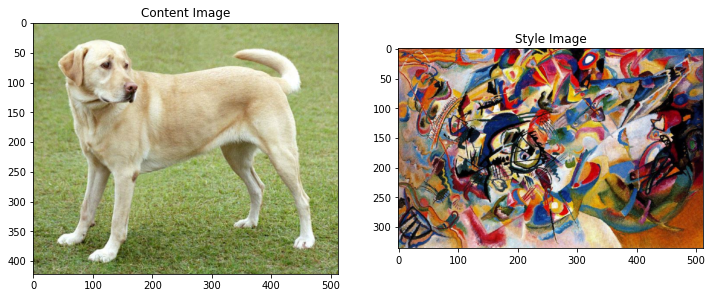

In [7]:
content_image = load_img(content_path)
style_image = load_img(style_path)

plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

# import tensorflow_hub as hub
# hub_module = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/1')
# stylized_image = hub_module(tf.constant(content_image), tf.constant(style_image))[0]
# tensor_to_image(stylized_image)

In [8]:
x = tf.keras.applications.vgg19.preprocess_input(content_image*255)
x = tf.image.resize(x, (224, 224))
vgg = tf.keras.applications.VGG19(include_top=True, weights='imagenet')
prediction_probabilities = vgg(x)
prediction_probabilities.shape

TensorShape([1, 1000])

In [9]:
predicted_top_5 = tf.keras.applications.vgg19.decode_predictions(prediction_probabilities.numpy())[0]
[(class_name, prob) for (number, class_name, prob) in predicted_top_5]

[('Labrador_retriever', 0.49317124),
 ('golden_retriever', 0.23665299),
 ('kuvasz', 0.036357492),
 ('Chesapeake_Bay_retriever', 0.024182752),
 ('Greater_Swiss_Mountain_dog', 0.018646091)]

In [28]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

for layer in vgg.layers:
    print(layer.name)

input_6
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [11]:
content_layers = ['block5_conv2'] 

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [12]:
def vgg_layers(layer_names):
    """ 중간층의 출력값을 배열로 반환하는 vgg 모델을 만듭니다."""
    # 이미지넷 데이터셋에 사전학습된 VGG 모델을 불러옵니다
    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False

    outputs = [vgg.get_layer(name).output for name in layer_names]

    model = tf.keras.Model([vgg.input], outputs)
    return model

In [13]:
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)

# 각 층의 출력에 대한 통계량을 살펴봅니다
for name, output in zip(style_layers, style_outputs):
    print(name)
    print("  크기: ", output.numpy().shape)
    print("  최솟값: ", output.numpy().min())
    print("  최댓값: ", output.numpy().max())
    print("  평균: ", output.numpy().mean())


block1_conv1
  크기:  (1, 336, 512, 64)
  최솟값:  0.0
  최댓값:  835.5256
  평균:  33.97525
block2_conv1
  크기:  (1, 168, 256, 128)
  최솟값:  0.0
  최댓값:  4625.8857
  평균:  199.82687
block3_conv1
  크기:  (1, 84, 128, 256)
  최솟값:  0.0
  최댓값:  8789.239
  평균:  230.78099
block4_conv1
  크기:  (1, 42, 64, 512)
  최솟값:  0.0
  최댓값:  21566.135
  평균:  791.24005
block5_conv1
  크기:  (1, 21, 32, 512)
  최솟값:  0.0
  최댓값:  3189.2542
  평균:  59.179478


In [14]:
def gram_matrix(input_tensor):
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
    return result/(num_locations)

In [36]:
class StyleContentModel(tf.keras.models.Model):
    def __init__(self, style_layers, content_layers):
        super(StyleContentModel, self).__init__()
        self.vgg =  vgg_layers(style_layers + content_layers)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        self.vgg.trainable = False

    def call(self, inputs):
        "[0,1] 사이의 실수 값을 입력으로 받습니다"
        inputs = inputs*255.0
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
        outputs = self.vgg(preprocessed_input)
        style_outputs, content_outputs = (outputs[:self.num_style_layers], 
                                          outputs[self.num_style_layers:])
        "gram matrix가 dimension을 낮추는 역할"
        style_outputs = [gram_matrix(style_output)
                         for style_output in style_outputs]

        content_dict = {content_name:value 
                        for content_name, value 
                        in zip(self.content_layers, content_outputs)}

        style_dict = {style_name:value
                      for style_name, value
                      in zip(self.style_layers, style_outputs)}
        
        return {'content':content_dict, 'style':style_dict}

In [37]:
extractor = StyleContentModel(style_layers, content_layers)

results = extractor(tf.constant(content_image))

print('스타일:')
for name, output in sorted(results['style'].items()):
    print("  ", name)
    print("    크기: ", output.numpy().shape)
    print("    최솟값: ", output.numpy().min())
    print("    최댓값: ", output.numpy().max())
    print("    평균: ", output.numpy().mean())
    print()

print("콘텐츠:")
for name, output in sorted(results['content'].items()):
    print("  ", name)
    print("    크기: ", output.numpy().shape)
    print("    최솟값: ", output.numpy().min())
    print("    최댓값: ", output.numpy().max())
    print("    평균: ", output.numpy().mean())


[<tf.Tensor: shape=(1, 422, 512, 64), dtype=float32, numpy=
array([[[[0.00000000e+00, 0.00000000e+00, 1.00046444e+01, ...,
          0.00000000e+00, 1.01990786e+01, 5.17501736e+00],
         [0.00000000e+00, 0.00000000e+00, 2.26321545e+01, ...,
          0.00000000e+00, 4.79739265e+01, 4.10096664e+01],
         [0.00000000e+00, 0.00000000e+00, 1.73914948e+01, ...,
          0.00000000e+00, 3.29855270e+01, 2.15411110e+01],
         ...,
         [0.00000000e+00, 0.00000000e+00, 1.14660015e+01, ...,
          1.17824078e-01, 1.61485844e+01, 1.52005949e+01],
         [0.00000000e+00, 0.00000000e+00, 8.68068314e+00, ...,
          1.94504821e+00, 1.42712126e+01, 9.52732849e+00],
         [0.00000000e+00, 0.00000000e+00, 2.56639838e+00, ...,
          2.02222538e+00, 3.94720173e+00, 0.00000000e+00]],

        [[0.00000000e+00, 0.00000000e+00, 5.80722427e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [8.82366371e+00, 0.00000000e+00, 2.20076180e+01, ...,
       

In [17]:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

In [18]:
image = tf.Variable(content_image)


In [19]:
def clip_0_1(image):
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [20]:
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)


In [21]:
style_weight=1e-2
content_weight=1e4

In [22]:
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

In [23]:
@tf.function()
def train_step(image):
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        loss = style_content_loss(outputs)

    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    image.assign(clip_0_1(image))

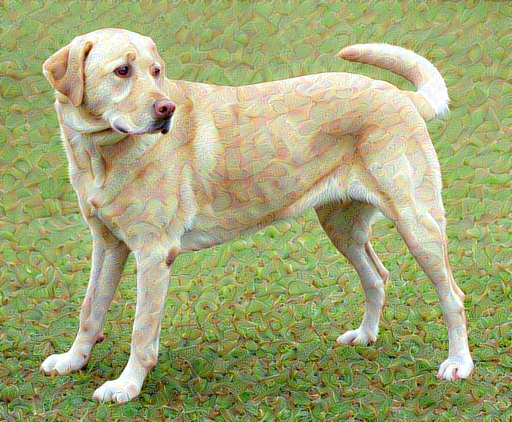

In [24]:
train_step(image)
train_step(image)
train_step(image)
tensor_to_image(image)

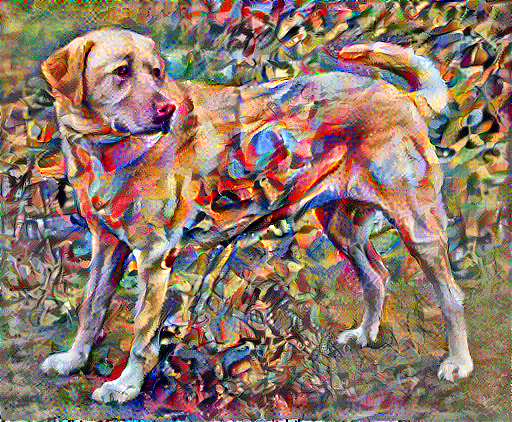

훈련 스텝: 1000
전체 소요 시간: 33.8


In [26]:
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
    for m in range(steps_per_epoch):
        step += 1
        train_step(image)
        print(".", end='')
    display.clear_output(wait=True)
    display.display(tensor_to_image(image))
    print("훈련 스텝: {}".format(step))
  
end = time.time()
print("전체 소요 시간: {:.1f}".format(end-start))

In [38]:
def high_pass_x_y(image):
    x_var = image[:,:,1:,:] - image[:,:,:-1,:]
    y_var = image[:,1:,:,:] - image[:,:-1,:,:]

    return x_var, y_var

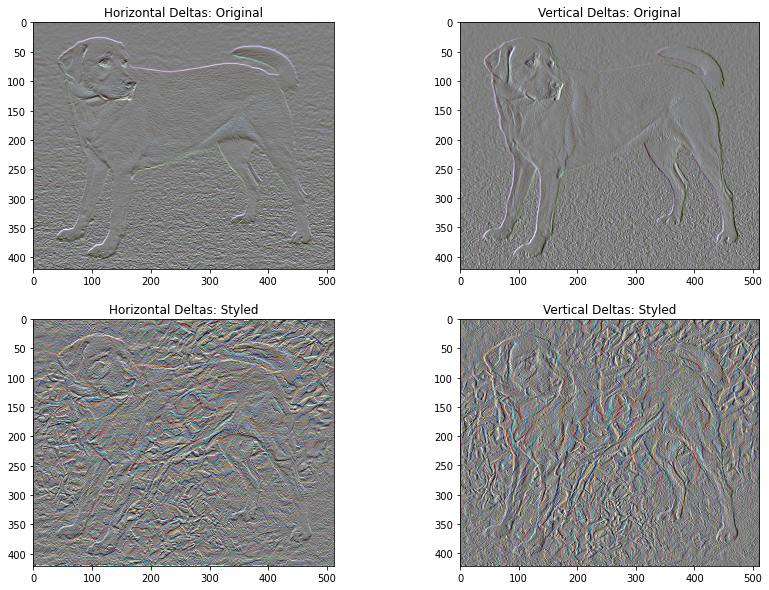

In [41]:
x_deltas, y_deltas = high_pass_x_y(content_image)

plt.figure(figsize=(14,10))
plt.subplot(2,2,1)
imshow(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas: Original")

plt.subplot(2,2,2)
imshow(clip_0_1(2*x_deltas+0.5), "Vertical Deltas: Original")

x_deltas, y_deltas = high_pass_x_y(image)

plt.subplot(2,2,3)
imshow(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas: Styled")

plt.subplot(2,2,4)
imshow(clip_0_1(2*x_deltas+0.5), "Vertical Deltas: Styled")

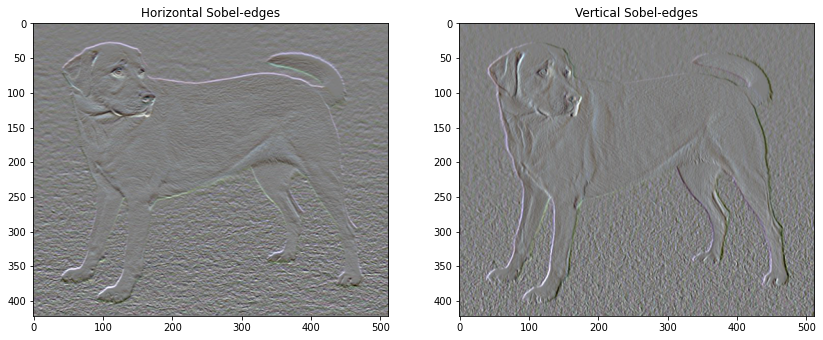

In [42]:
plt.figure(figsize=(14,10))

sobel = tf.image.sobel_edges(content_image)
plt.subplot(1,2,1)
imshow(clip_0_1(sobel[...,0]/4+0.5), "Horizontal Sobel-edges")
plt.subplot(1,2,2)
imshow(clip_0_1(sobel[...,1]/4+0.5), "Vertical Sobel-edges")

In [43]:
def total_variation_loss(image):
    x_deltas, y_deltas = high_pass_x_y(image)
    return tf.reduce_sum(tf.abs(x_deltas)) + tf.reduce_sum(tf.abs(y_deltas))

In [44]:
total_variation_loss(image).numpy()


146652.47

In [45]:
tf.image.total_variation(image).numpy()


array([146652.47], dtype=float32)

In [46]:
total_variation_weight=30


In [48]:
@tf.function()
def train_step(image):
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        loss = style_content_loss(outputs)
        loss += total_variation_weight*tf.image.total_variation(image)

    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    image.assign(clip_0_1(image))

In [49]:
image = tf.Variable(content_image)


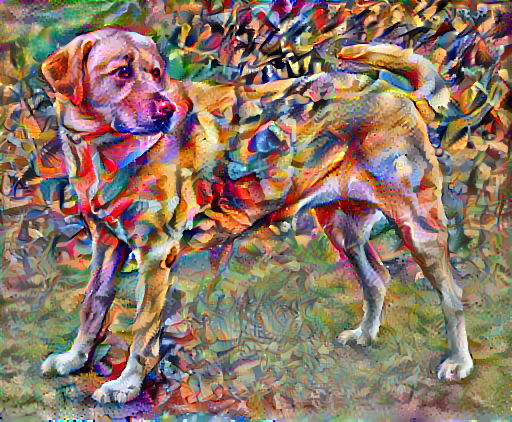

훈련 스텝: 1000
전체 소요 시간: 32.3


In [50]:
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
    for m in range(steps_per_epoch):
        step += 1
        train_step(image)
    print(".", end='')
    display.clear_output(wait=True)
    display.display(tensor_to_image(image))
    print("훈련 스텝: {}".format(step))

end = time.time()
print("전체 소요 시간: {:.1f}".format(end-start))

In [51]:
file_name = 'stylized-image.png'
tensor_to_image(image).save(file_name)

try:
    from google.colab import files
except ImportError:
    pass
else:
    files.download(file_name)